<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20PredictionCourse4_Part2_Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

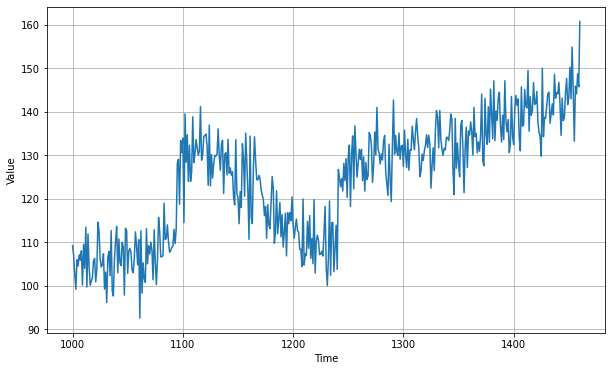

In [4]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
i = 0
for x, y in dataset:
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  i += 1
  if i == 1:
    break

x =  [[ 96.42854     89.44822    100.03024     99.57818    107.219124
   94.91636     97.603714    97.8079     104.50157     96.191444
   98.11696     99.815544    97.76361     94.65319     97.910904
  102.363976    91.91891     97.77226     93.663025   103.19536   ]
 [ 35.65456     25.80494     34.77235     32.066845    34.161064
   39.582893    28.920498    26.427605    25.797895    26.215937
   29.959328    32.100777    31.828976    34.632267    30.61251
   37.86664     29.327465    44.30369     33.883587    26.522177  ]
 [ 89.86424     93.24602     89.7542      89.53318     93.84538
   86.341194    89.16745     86.13896     86.03953     86.42608
   88.840904    85.093254    93.521095    82.52326     85.814674
   84.30198     93.48608     86.98358     90.90881     78.06983   ]
 [ 93.521095    82.52326     85.814674    84.30198     93.48608
   86.98358     90.90881     78.06983     86.580284    89.440056
   85.149765    89.81185     81.64388     91.022804    95.216286
   81.653404   

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [17]:
model.fit(dataset, epochs=100, verbose=0)

In [22]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

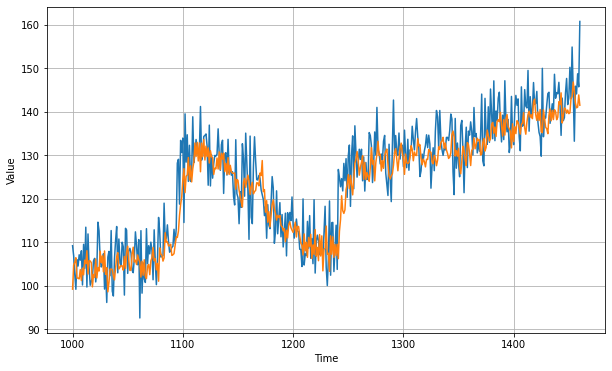

In [23]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.926383